#**Ch03. 평가**
* 머신러닝은 데이터 가공/변환, 모델 학습/예측, 그리고 평가의 프로세스로 구성됨
* 예측 성능을 평가하는 방법 : 성능평가지표(Evaluation Metric)
  * 회귀 : 실제값과 예측값의 오차 평균값에 기반
  * 분류 : 실제 결과 데이터와 예측 겨로가 데이터가 얼마나 정확하고 오류가 적게 발생하는가에 기반


* 분류의 성능 평가 지표(이진/멀티, 이진에서 더욱 강조하는 지표)
  * 정확도(Accuracy)
  * 오차 행렬(Confusion Matrix)
  * 정밀도(Precision)
  * 재현율 (Recall)
  * F1 score
  * ROC AUC



##**01. 정확도(Accuracy)**
- 정확도 = 예측 결과가 동일한 데이터 건수/ 전체 예측 데이터 건수
- 정확도 지표가 어떻게 모델의 성능을 왜곡하는가?


---


사이킷런의 BaseEstimator 클래스를 활용하여, 단순히 성별에 따라 생존자를 예측하는 단순한 분류기를 생성

- 사이킷런의 BaseEsimators를 활용하면 Customized된 Estimator를 생성할 수 있음

In [4]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
  #fit()메서드는 아무것도 학습하지 않음
  def fit(self, X, y=None):
    pass
  #predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함
  def predict(self, X):
    pred = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
      if X['Sex'].iloc[i]==1:
        pred[i]=0
      else:
        pred[i]=1
    
    return pred

In [5]:
#MyDummyClassifier을 이용해 앞 장의 타이타닉 생존자 예측을 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import numpy as np
#Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(),inplace=True)
  df['Cabin'].fillna('N',inplace=True)
  df['Embarked'].fillna('N',inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

#머신러닝 알고리즘에 불필요한 속성제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'],axis=1, inplace=True)
  return df

#레이블 인코딩 수행
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('/content/drive/MyDrive/ESAA/22-2/DATA/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf=MyDummyClassifier()
myclf.fit(X_train,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifier의 정확도는: 0.7877


-> 단순 알고리즘으로 예측하는 경우에도 데이터의 구성에 따라 정확도 결과는 78.77%로 매우 높게 나올 수 있음


---

- MNIST 데이터 세트를 변환하여 불균형한 데이터 세트를 만든 뒤 정확도 지표 적용시 어떤 문제가 발생할 수 있는지 살펴보기

- **MNIST 데이터세트** : 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 Digit을 예측하는데 사용
  - 0부터 9까지의 멀티레이블이지만 레이블 값이 7인 것만 True, 나머지는 False인 불균형한 데이터 세트로 변환
  - 이후에 모든 데이터를 False(0)으로 예측하는 분류기를 만들어 정확도를 측정
결과적으로 아무것도 하지 않고, 특정 결과로만 결과를 반환해도 정확도가 높게 측정되어 모델 성능이 높게 나타나는 현상이 발생

In [7]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

# 사이킷런의 내장 데이터 셋인 load_digits()를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True이고 이를 astype(int)로 1로 변환, 7이 아니면 False이고 0으로 변환
y=(digits.target == 7).astype(int)

# 훈련셋, 테스트셋으로 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [11]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 데이터 크기: ', y_test.shape)
print('테스트 데이터 세트 레이블 0과 1의 분포도: ')
print(pd.Series(y_test).value_counts())

# FakeClassifier를 통해 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 데이터 크기:  (450,)
테스트 데이터 세트 레이블 0과 1의 분포도: 
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


##**02. 오차 행렬(Confusion matrix)**

예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표

**오차행렬**
: 4분면으로 나누어 왼쪽, 오른쪽을 예측된 클래스 값 기준으로 Negative와 Positive로 분류, 위 아래를 실제 클래스 값 기준으로 Negative와 Positive로 분류

- TN: True Negative
- FP: False Positive
- FN: False Negative
- TP: True Positive

사이킷런의 오차행렬 API: `confusion_matrix()`

In [12]:
from sklearn.metrics import confusion_matrix
# y_test:실제 결과, fakepred:예측 결과
confusion_matrix(y_test,fakepred) # ndarray형태

array([[405,   0],
       [ 45,   0]])

**정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)**

- 불균형한 이진 분류 데이터 세트에서는 중점적으로 찾아야 하는 매우 적은 경우의 수의 결과값에 Positive를 설정해 1 부여, 그렇지 않은 경우 Negative으로 0 부여

- Positive 데이터 건수가 매우 작기 때문에 Negative로 예측 정확도가 높아지는 경향이 발생

## **03. 정밀도와 재현율**

Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춤

**정밀도 = TP / (FP + TP)**

**재현율 = TP / (FN + TP)**

정밀도는 예측을 Positive로 한 대상 중 예측과 실제 값이 Positive로 일치한 데이터 비율

재현율은 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터 비율 (=민감도,TPR)

- 재현율이 중요 지표인 경우 : 실제 positive 양성 데이터를 negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우, FN 낮춤
  - ex) 암 판단 모델, 금융 사기 적발 모델

- 정밀도가 중요 지표인 경우 : 실제 negative 음성인 데이터 예측을 positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우, FP 낮춤
  - ex) 스팸 메일 여부를 판단하는 모델

- `precision_score()` : 사이킷런의 정밀도 계산
- `recall_score()` : 재현율 계산
- `get_clf_eval()` : 오차행렬, 정확도, 정밀도, 재현율 모두 구해서 예측 성능 평가

In [13]:
from sklearn.metrics import accuracy_score,precision_score,precision_score,recall_score,confusion_matrix

def get_clf_eval(y_test,pred):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  print('정확도:{0:.4f},정밀도:{1:.4f},재현율:{2:.4f}'.format(accuracy,precision,recall))

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('/content/drive/MyDrive/ESAA/22-2/DATA/titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train,X_test,y_train,y_test=train_test_split(X_titanic_df,y_titanic_df,test_size=0.20,random_state=11)

lr_clf=LogisticRegression()

lr_clf.fit(X_train,y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742,재현율:0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### **정밀도/재현율 트레이드오프**

정밀도와 재현율은 상호 보완적인 평가 지표이므로 한쪽을 강제로 높이면 다른 하나는 수치가 떨어짐

사이킷런의 분류 알고리즘은 각각 레이블별 결정 확률을 구하고 더 큰 확률을 가진 것을 예측값으로 함

**predict_proba( )**: 예측 확률을 반환

In [15]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba( ) 의 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

pred_proba_result=np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba( ) 의 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46191519 0.53808481]
 [0.878675   0.121325  ]
 [0.87716185 0.12283815]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46191519 0.53808481 1.        ]
 [0.878675   0.121325   0.        ]
 [0.87716185 0.12283815 0.        ]]


In [16]:
from sklearn.preprocessing import Binarizer

X=[[1, -1, 2],
   [2, 0, 0],
   [0, 1.1, 1.2]]
#X의 개별 원소들이 threshold값보다 같거나 작으면 0, 크면 1을 반환
binarizer=Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))
#1.1보다 크면 1을 갖도록

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [17]:
#predict의 preudo코드
from sklearn.preprocessing import Binarizer
#Binarizer의 threshold 설정값, 분류 결정 임곗값
custom_threshold=0.5

#predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1=pred_proba[:,1].reshape(-1,1)

binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict) #predict는 predict_proba()에 기반함

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742,재현율:0.7869


In [18]:
#Binarizer의 threshold 설정값을 0.4로 설정, 분류 결정 임곗값을 0.5에서 0.4로 낮춘 경우
custom_threshold=0.4

pred_proba_1=pred_proba[:,1].reshape(-1,1)

binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324,정밀도:0.7183,재현율:0.8361


- Positive 예측값이 많아지면 재현율이 높아짐 (양성 예측 증가, 실제 양성을 음성으로 예측하는 횟수가(FN) 작아지기 때문)
- 임곗값을 낮추는 경우 FN감소 FP증가


In [19]:
#테스트를 수행할 모든 임곘값을 리스트 객체로 저장
thresholds=[0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  #thresholds list 객체 내의 값을 차례로 iteration 하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
    custom_predict=binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test,custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도:0.8324,정밀도:0.7183,재현율:0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도:0.8492,정밀도:0.7656,재현율:0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742,재현율:0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도:0.8659,정밀도:0.8364,재현율:0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도:0.8771,정밀도:0.8824,재현율:0.7377


- `precision_recall_curve()` : 임곗값 변화에 따른 평가 지표 값을 알아보는 코드
  - 입력 파라미터
    - y_true : 실제 클래스값 배열(배열 크기=[데이터 건수])
    - probas_pred : positive 칼럼의 예측 확률 배열 (배열 크기 = [데이터 건수])
  - 반환 값 
    - 정밀도 : 임곗값별 정밀도 값을 배열로 변환
    - 재현율 : 임곗값별 재현율 값을 배열로 변환


In [20]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 Step으로 추출
thr_index=np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

#15step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))


반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


In [21]:
#정밀도 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

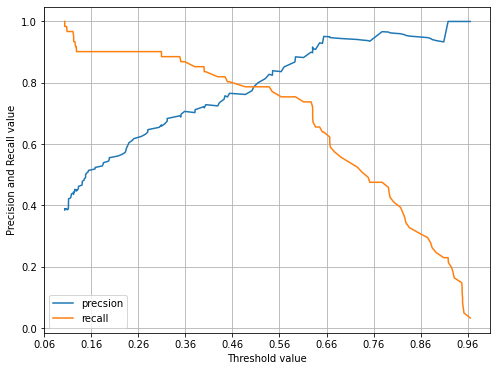

In [22]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
  #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  #X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary=thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-', label='precsion')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  #threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end=plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1),2))

  #x축, y축 label과 legend, grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend( ); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

#### **정밀도와 재현율의 맹점**

임곗값을 변경함에 따라 정밀도와 재현율의 수치가 변경됨
-> 그러므로 두 개의 수치를 상호 보완할 수 있는 수준에서 적용

- 정밀도 100%가 되는 방법

  - 확실한 기준이 되는 경우만 Positice로 예측하고 나머지는 모두 Negative로 예측, FP=0, TP=1

- 재현율이 100%가 되는 방법

  - 모든 환자를 Positive로 예측, TP=n, FN=0

## **04. F1 스코어**

- 정밀도와 재현율을 결합한 지표
- 정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐

In [23]:
from sklearn.metrics import f1_score
f1=f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [24]:
#get_clf_eval() 함수에 F1 스코어 추가

def get_clf_eval(y_test, pred):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)
  #F1 스코어 추가
  f1=f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  #F1 스코어 프린트 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds=[0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba=lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1: 0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


## **05. ROC 곡선과 AUC**

- ROC 곡선: 수신자 판단 곡선, FPR을 X축, TPR을 Y축으로
- TPR=True Positive Rate=재현율, 민감도=**TP/(FN + TP)**
- TNR=True Negative Rate=특이성=**TN/(FP + TN)**
- FPR=False Positive Rate= 1- 특이성=**FP/(FP + TN)**

- 민감도 : 실제값 positive가 정확히 예측돼야 하는 수준을 나타냄( 질병이 있는 사람은 질병이 있는 것으로 양성 판정)
- 특이성 : 실제값 negative가 정확히 예측돼야 하는 수준을 나타냄( 질병이 없는 사람은 질병이 없는 사람으로 음성 판정)
---

ROC 곡선은 대각선으로 이은 직선과 멀수록 성능이 좋고 가까울수록 성능이 안좋음

FPR을 변경하면서 TPR의 변화 값을 구함

FPR=0 : 임곗값이 1 = positive로 예측하는 경우가 없으므로 FP=0

FPR=1 : 임곗값이 0 = 전부 positive로 예측하므로 TN=0이 됨

---
- `roc_curve( )`

  - 입력 파라미터 
    - y_true: 실제 클래스 값 arrary(array shape=[데이터 건수])
    - y_score: predict_proba의 반환 값, array에서 positive 칼럼의 예측 확률이 보통 사용됨 (array shape=[n_samples])
  - 반환값 : fpr,tpr,thresholds 값 array


In [25]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds=roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5step으로 추출
#threshold[0]은 max(예측확률)+1로 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index=np.arange(1, thresholds.shape[0],5)

print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ',np.round(thresholds[thr_index],2))

print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


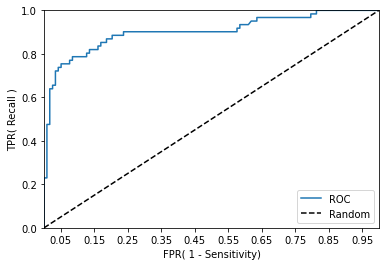

In [26]:
def roc_curve_plot(y_test, pred_proba_c1):
  # 임곘값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds=roc_curve(y_test, pred_proba_c1)
  # ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs, tprs, label='ROC')
  # 가운데 대각선 직선을 그림
  plt.plot([0,1],[0,1], 'k--', label='Random')

  # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))
  plt.xlim(0,1); plt.ylim(0,1)
  plt.xlabel('FPR( 1 - Sensitivity)'); plt.ylabel('TPR( Recall )')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

- ROC 곡선 자체를 FPR과 TPR의 변화 값을 보는 데 이용
- AUC(Area Under Curve) : ROC 곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋은 수치

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_test, pred))
print('정확도: ', np.round(accuracy_score(y_test, pred), 4))
print('정밀도: ', np.round(precision_score(y_test, pred), 4))
print('재현율: ', np.round(recall_score(y_test, pred), 4))

[[104  14]
 [ 13  48]]
정확도:  0.8492
정밀도:  0.7742
재현율:  0.7869


In [36]:
#get_clf_eval에 ROC AUC 값추가

def get_clf_eval(y_test, pred=None,pred_proba=None):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)
  f1=f1_score(y_test, pred)
  #ROC-AUC 추가
  roc_auc=roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


## **06.피마 인디언 당뇨병 예측**
피마 인디언 당뇨병(Pima Indian Diabetes) : 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터 , 고립된 유전적 특성에 대한 연구



In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv("/content/drive/MyDrive/ESAA/22-2/DATA/diabetes.csv")
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [30]:
diabetes_data.info()
#Null값은 없으며 피처의 타입은 모두 숫자형

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [37]:
#피처 데이터 세트 X, 레이블데이터 y를 추출
#맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=156, stratify=y)

#로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,pred,pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1: 0.6392, AUC:0.7919


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


- 전체 데이터의 65%가 Negative 이므로 정확도보다는 재현율 성능에 더 초점을 맞춤

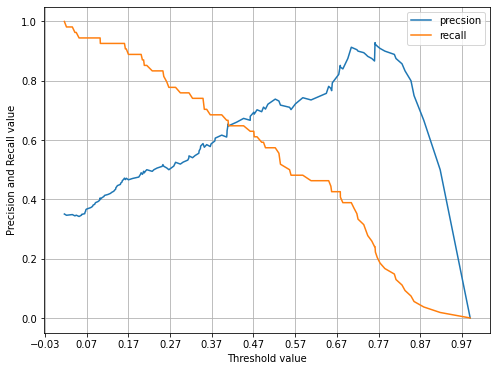

In [38]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test,pred_proba_c1)

In [39]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- min()값이 0으로 되어 있는 피처가 상당히 많음

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

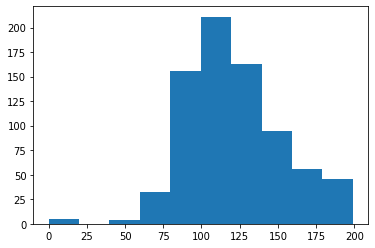

In [40]:
plt.hist(diabetes_data['Glucose'],bins=10)

- min()값이 0으로 되어 있는 피처에 대해 0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인

In [41]:
#0값을 검사할 피처 명 리스트
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

#전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

#피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
  zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
  print('{0} 0 건수는 {1}, 퍼센트는 {2: .2f} %'.format(feature, zero_count,100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는  0.65 %
BloodPressure 0 건수는 35, 퍼센트는  4.56 %
SkinThickness 0 건수는 227, 퍼센트는  29.56 %
Insulin 0 건수는 374, 퍼센트는  48.70 %
BMI 0 건수는 11, 퍼센트는  1.43 %


In [43]:
#zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0,mean_zero_features)

- 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋음
- 이후 다시 학습/ 테스트 데이터 세트로 나누고 로지스틱 회귀를 적용해 성능 평가 지표 확인

In [49]:
X=diabetes_data.iloc[:,:-1] #마지막 컬럼 제외한 나머지
y=diabetes_data.iloc[:,-1] #마지막 컬럼만

#StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2, random_state=156, stratify=y)

#로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
pred=lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC:0.8433


- 데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선됨, 여전히 재현율 수치 개선 필요
- 분류 임곗값 변화시키며 어느 정도 개선되는지 확인

In [51]:
# thresholds = [0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.50]
# pred_proba = lr_clf.predict_proba(X_test)
# get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

In [52]:
#임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)
#위에서 구한 lr_clf의 predict_proba() 예측 확률 array 에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
get_clf_eval(y_test,pred_th_048,pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC:0.8433


##**07.정리**

- 이진 분류의 레이블 값이 불균형하게 분포될 경우(즉 0이 매우 많고, 1이 매우 적을 경우 또는 반대의 경우) 단순히 예측 결과와 실제 결과가 일치하는 지표인 정확도만으로는 머신러닝 모델의 예측 성능을 평가할 수 없다.
- 오차 행렬은 Negative 와 Positive 값을 가지는 실제 클래스 값과 예측 클래스 값이 True와 False에 따라 TN,FP,FN,TP로 매핑되는 4분면 행렬을 기반으로 예측 성능을 평가한다.
- 정밀도와 재현율은 positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가지표이다. Threshold 임곗값을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.
- F1 스코어는 정밀도와 재현율을 결합한 평가 지표이며, 정밀도와 재현율이 어느 한 쪽으로 치우치지 않을 때 높은 지표값을 가지게 된다. AUC 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다.